<a href="https://colab.research.google.com/github/Sahel-Eskandar/Project-Notebooks/blob/main/1_LogReg_XGB_MLP_CLF_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline 

#Data Prepration

In [ ]:
path_y = Output + 'df_y.csv'
path_X = Output + 'df_X.csv'

In [ ]:
X = pd.read_csv(path_X)
y = pd.read_csv(path_y)

In [ ]:
print(y.shape)
print(X.shape)

(69790, 1)
(69790, 10)


##### KFold cross validation

In [ ]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 4)
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 4)

In [ ]:
for train_index,test_index in kf.split(X,y):
    X_train,X_test = X.loc[train_index],X.loc[test_index]
    y_train,y_test = y.loc[train_index],y.loc[test_index]

#Model Training & Evaluation

###### Logistic regression model

In [ ]:
logreg = LogisticRegression()
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg_cv=GridSearchCV(logreg,grid,cv=10)
model = logreg_cv.fit(X_train, y_train)
y_pred = logreg_cv.predict(X_test)

In [ ]:
scores = logreg_cv.score(X_test,y_test)

In [ ]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(scores))

Accuracy of logistic regression classifier on test set: 0.85


In [ ]:
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[2876,  566],
       [ 469, 3068]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3442
           1       0.84      0.87      0.86      3537

    accuracy                           0.85      6979
   macro avg       0.85      0.85      0.85      6979
weighted avg       0.85      0.85      0.85      6979



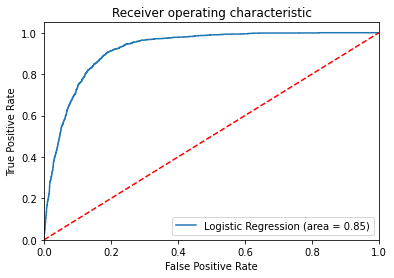

In [ ]:
logit_roc_auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, logreg_cv.predict_proba(X_test)[:,1])


plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
def logreg(X, y, cv):
    """
    Creates folds manually, perform 
    Returns an array of validation (recall) scores
    """
    if cv == 'kf':
        cv = KFold(n_splits = 10, shuffle = True, random_state = 4)
    elif cv == 'skf':
        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 4)
    else:
        cv == None
    
    scores = []
    logreg = LogisticRegression()
    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
    logreg_cv=GridSearchCV(logreg,grid,cv=10)
    for train_index,test_index in cv.split(X,y):
        X_train,X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]

        # Fit the model on the training data
        model_obj = logreg_cv.fit(X_train, y_train)
        # Score the model on the validation data
        score = recall_score(y_test, model_obj.predict(X_test))
        scores.append(score)
    return np.array(scores).mean()


In [ ]:
logreg(X, y, kf)

0.8569456268661846

In [ ]:
logreg(X, y, skf)

0.8572003702179835

In [ ]:
from sklearn.metrics import confusion_matrix
def model_classifier(model, X, y, cv):
    """
    Creates folds manually, perform 
    Returns an array of validation (recall) scores
    """
    if cv == 'kf':
        cv = KFold(n_splits = 10, shuffle = True, random_state = 4)
    elif cv == 'skf':
        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 4)
    else:
        cv == None
    
    scores = []
    
    
    for train_index,test_index in cv.split(X,y):
        X_train,X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]

        # Fit the model on the training data
        model_obj = model.fit(X_train, y_train)
        y_pred = model_obj.predict(X_test)
        # Score the model on the validation data
        score = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred) 
        
        scores.append(score)
        mean_score = np.array(scores).mean()
    import seaborn as sns
    array = conf_matrix
    #df_cm = pd.DataFrame(array, index = ['No','Yes'], columns = ['No','Yes'])
    plt.figure(figsize = (6,4))
    #sns.heatmap(df_cm, annot=True,fmt='d')
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in array.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in array.flatten()/np.sum(array)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(array, annot=labels, fmt='', cmap='Blues')
    print('\n Accuracy scores of the model: {:.2f}'.format(mean_score))
    print('\n Classification report of the model')
    print('--------------------------------------')
    print(report)
    
    print('\n Confusion Matrix of the model')
    print('--------------------------------------')
    #print(conf_matrix)
    
    


In [ ]:
logreg = LogisticRegression()


 Accuracy scores of the model: 0.84

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3442
           1       0.84      0.87      0.86      3537

    accuracy                           0.85      6979
   macro avg       0.85      0.85      0.85      6979
weighted avg       0.85      0.85      0.85      6979


 Confusion Matrix of the model
--------------------------------------
CPU times: user 2.34 s, sys: 1.52 s, total: 3.86 s
Wall time: 3.03 s


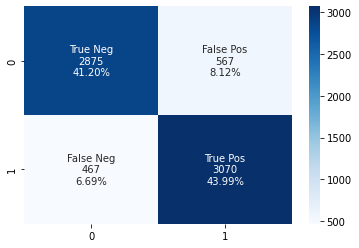

In [ ]:
%%time
model_classifier(logreg, X, y, kf)


 Accuracy scores of the model: 0.84

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3489
           1       0.84      0.87      0.85      3490

    accuracy                           0.85      6979
   macro avg       0.85      0.85      0.85      6979
weighted avg       0.85      0.85      0.85      6979


 Confusion Matrix of the model
--------------------------------------


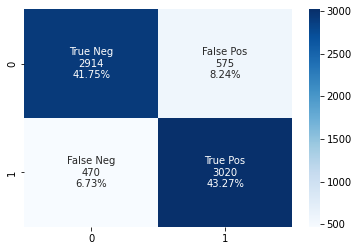

In [ ]:
model_classifier(logreg, X, y, skf)

In [ ]:
xgb = XGBClassifier()


 Accuracy scores of the model: 0.87

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      3442
           1       0.86      0.92      0.89      3537

    accuracy                           0.88      6979
   macro avg       0.88      0.88      0.88      6979
weighted avg       0.88      0.88      0.88      6979


 Confusion Matrix of the model
--------------------------------------
CPU times: user 46.6 s, sys: 132 ms, total: 46.7 s
Wall time: 46.6 s


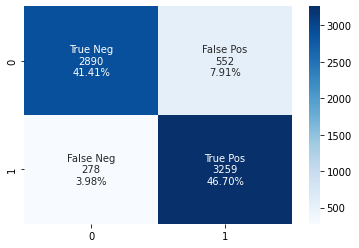

In [ ]:
%%time
model_classifier(xgb, X, y, kf)


 Accuracy scores of the model: 0.87

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      3489
           1       0.85      0.91      0.88      3490

    accuracy                           0.87      6979
   macro avg       0.88      0.87      0.87      6979
weighted avg       0.88      0.87      0.87      6979


 Confusion Matrix of the model
--------------------------------------


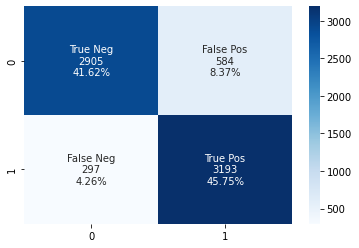

In [ ]:
model_classifier(xgb, X, y, skf)

In [ ]:
mlp = MLPClassifier()


 Accuracy scores of the model: 0.90

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      3442
           1       0.87      0.95      0.91      3537

    accuracy                           0.91      6979
   macro avg       0.91      0.91      0.91      6979
weighted avg       0.91      0.91      0.91      6979


 Confusion Matrix of the model
--------------------------------------
CPU times: user 14min 13s, sys: 11min 23s, total: 25min 37s
Wall time: 13min 12s


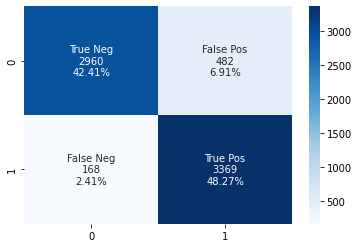

In [ ]:
%%time
model_classifier(mlp, X, y, kf)


 Accuracy scores of the model: 0.89

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      3489
           1       0.87      0.95      0.91      3490

    accuracy                           0.91      6979
   macro avg       0.91      0.91      0.91      6979
weighted avg       0.91      0.91      0.91      6979


 Confusion Matrix of the model
--------------------------------------


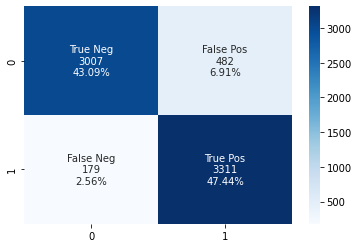

In [ ]:
model_classifier(mlp, X, y, skf)

In [ ]:
clf = svm.SVC(kernel='linear')


 Accuracy scores of the model: 0.85

 Classification report of the model
--------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3442
           1       0.84      0.89      0.86      3537

    accuracy                           0.86      6979
   macro avg       0.86      0.86      0.86      6979
weighted avg       0.86      0.86      0.86      6979


 Confusion Matrix of the model
--------------------------------------
CPU times: user 18min, sys: 2.66 s, total: 18min 3s
Wall time: 18min


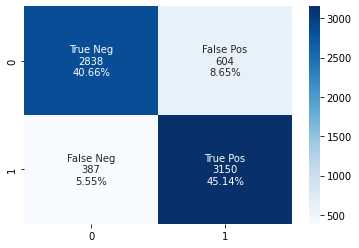

In [ ]:
%%time
model_classifier(clf, X, y, kf)

###### ROC plots 

In [ ]:
def roc_plot(model, X, y, cv):
    for train_index,test_index in cv.split(X,y):
        X_train,X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]
        model_obj = model.fit(X_train, y_train)
        y_pred = model_obj.predict(X_test)
        y_pred_prob = model_obj.predict_proba(X_test)[:,1]
        
        logit_roc_auc = roc_auc_score(y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure()
    val_model = input("Enter your model name: ")
    plt.plot(fpr, tpr, label= val_model + ' (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    my_fig = val_model + '.png'
    #plt.savefig(os.path.join(my_path, my_fig))
    plt.show()

Enter your model name: Logistic Regression 


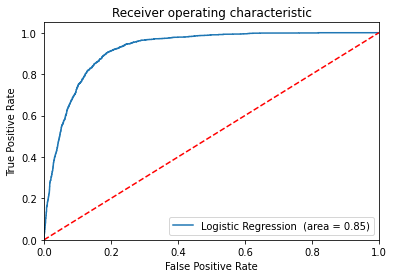

In [ ]:
roc_plot(logreg, X, y, kf)

Enter your model name: Logistic Regression skf


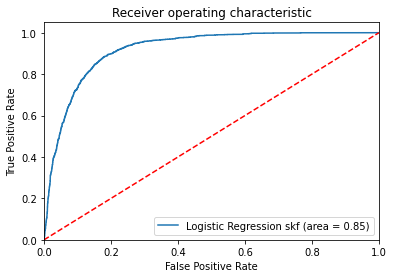

In [ ]:
roc_plot(logreg, X, y, skf)

Enter your model name: XGBoost


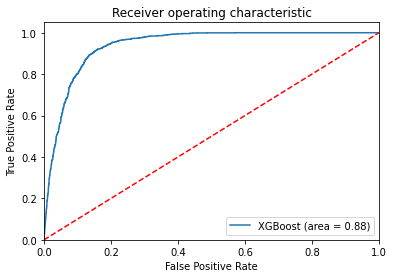

In [ ]:
roc_plot(xgb, X, y, kf)

Enter your model name: XGBoost skf


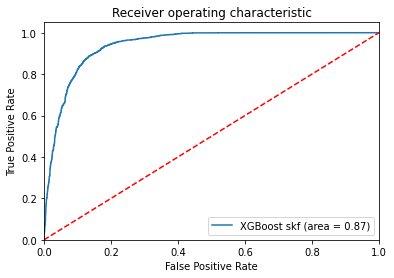

In [ ]:
roc_plot(xgb, X, y, skf)

Enter your model name: MLP


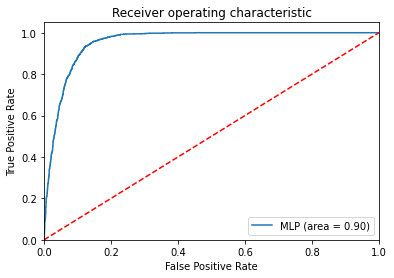

In [ ]:
roc_plot(mlp, X, y, kf)